In [12]:
import importlib
import os
import subprocess
import pandas as pd
import platform
import pathlib
import requests
from io import StringIO
import numpy as np
from annotations import *
from extract_video_features import *
import matplotlib.pyplot as plt 
import seaborn as sns

from tqdm import tqdm

import extract_video_features
importlib.reload(extract_video_features)
from extract_video_features import *

In [2]:
filename_annotations = 'https://docs.google.com/spreadsheets/d/1Rqu1sJiD-ogc4a6R491JTiaYacptOTqh6DKqhwTa8NA/gviz/tq?tqx=out:csv&sheet=Template'
features_folder = 'C:/Users/vince/Documents/TELECOM/Fil_Rouge/OpenFace/OpenFace_2.2.0/processed/'
video_folder = 'C:/Users/vince/Documents/TELECOM/Fil_Rouge/VideoAFPA'

In [3]:
video_names = [x.replace('.mp4','') for x in os.listdir(video_folder)]
video_names.remove('WIN_20210329_14_13_45_Pro')
video_names.remove('WIN_20210407_14_54_56_Pro_edit')
video_names.remove('WIN_20210403_18_49_15_Pro')
video_names.remove('WIN_20210407_15_02_22_Pro')

In [9]:
features_to_keep = [
'frame','face_id','timestamp','confidence','success',

'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r',
'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c',

'gaze_0_x','gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z',
'gaze_angle_x', 'gaze_angle_y', 
'pose_Tx', 'pose_Ty', 'pose_Tz','pose_Rx', 'pose_Ry', 'pose_Rz',

'type_candidat','sexe','video_name','stress_global','stress','diapo'
]

In [10]:
list_df = []
aggreg = 'max'
for v_name in tqdm(video_names):
    df_annoted = get_df_video_with_annotations(features_folder, v_name, filename_annotations,aggreg)[features_to_keep]
    list_df.append(df_annoted)

100%|██████████| 24/24 [00:54<00:00,  2.27s/it]


In [36]:
to_drop = ['frame','face_id','timestamp','confidence','success']

list_df_with_dist=[]
for i in tqdm(list_df):
    l=add_dist_features(i)
    l.drop(to_drop,axis='columns', inplace=True)
    list_df_with_dist.append(l)


groupby_features = ['video_name','stress_global','stress','diapo','type_candidat','sexe','dist_head', 'dist_gaze_0', 'dist_gaze_1', 'dist_pose_x','dist_pose_y', 'dist_pose_z' ]

df = pd.concat(list_df_with_dist)
df = df.groupby(groupby_features).mean().reset_index()
df

100%|██████████| 24/24 [01:37<00:00,  4.06s/it]


,video_name,stress_global,stress,diapo,type_candidat,sexe,dist_head,dist_gaze_0,dist_gaze_1,dist_pose_x,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,Test_pour_AFPA,1,0,9,Stagiaire,H,44.467469,0.621534,0.705981,0.145665,...,0.119529,0.725589,0.016162,0.412795,0.094276,0.358249,0.531987,0.850168,0.027946,0.417845
1,Test_pour_AFPA,1,0,10,Stagiaire,H,41.696521,0.562944,0.645913,0.136381,...,0.122388,0.848756,0.008458,0.337811,0.017910,0.292537,0.502488,0.581095,0.009453,0.324378
2,Test_pour_AFPA,1,0,11,Stagiaire,H,46.746221,0.683707,0.727095,0.180677,...,0.063542,0.844444,0.095139,0.321181,0.075694,0.352778,0.412847,0.295139,0.004167,0.370139
3,Test_pour_AFPA,1,0,17,Stagiaire,H,67.720741,0.684854,0.738246,0.282390,...,0.470115,0.794253,0.075862,0.096552,0.095402,0.550575,0.632184,0.668966,0.005747,0.240230
4,Test_pour_AFPA,1,1,1,Stagiaire,H,35.959408,0.525630,0.567888,0.120576,...,0.028039,0.361569,0.353922,0.277255,0.242549,0.451176,0.122941,0.261569,0.006078,0.212549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,WIN_20210417_14_53_12_Pro,0,0,10,Stagiaire,F,45.825063,0.949746,1.151113,0.175213,...,0.002978,0.019355,0.173201,0.174690,0.129032,0.933499,0.145409,0.132506,0.000000,0.159305
188,WIN_20210417_14_53_12_Pro,0,0,11,Stagiaire,F,44.743198,0.942931,1.105028,0.179020,...,0.001731,0.003809,0.052632,0.049169,0.092452,0.930055,0.131579,0.074792,0.003809,0.168629
189,WIN_20210417_14_53_12_Pro,0,1,12,Stagiaire,F,53.671493,0.925096,1.154474,0.151404,...,0.002064,0.018167,0.000000,0.028902,0.218002,0.741949,0.183732,0.107969,0.001032,0.124690
190,WIN_20210417_14_53_12_Pro,0,1,17,Stagiaire,F,57.926143,0.837893,1.217370,0.200221,...,0.000000,0.067661,0.108945,0.329128,0.014908,0.994266,0.266055,0.331422,0.049312,0.232798


In [37]:
x = df.drop(['video_name','stress_global','stress','diapo','type_candidat'],axis=1)

#Replace string values
x.sexe = x.sexe.replace('H',0)
x.sexe = x.sexe.replace('F',1)

y = df[['stress']]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state = 42)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_pred,y_test,squared=False)
print('RMSE = ',rmse)

0.7469016461124699


In [38]:
#0.76 avec sexe & type candidat
#0.76 avec sexe 
#0.80 sans sexe

In [42]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


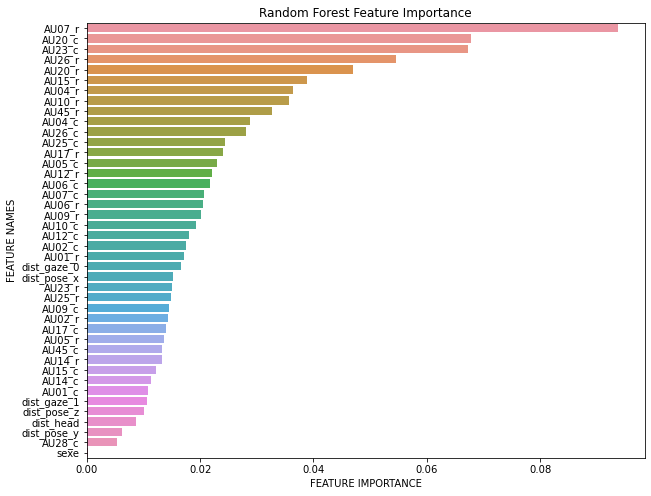

In [43]:
plot_feature_importance(model.feature_importances_,x_train.columns,'Random Forest') 